# 🎭 Identity-Aware Segmentation with SAM 3 & InsightFace

**โปรเจค:** ระบบ Segmentation ที่รู้จำตัวตนสำหรับสมาชิกวง IVE

**เทคโนโลยี:**
- SAM 3 (Segment Anything Model 3) - สำหรับ Segmentation
- InsightFace - สำหรับ Face Recognition
- RTX 6000 (48GB VRAM) Optimized

**สมาชิก IVE 6 คน:** Wonyoung, Yujin, Gaeul, Liz, Leeseo, Rei

---
## 📋 Table of Contents

1. [Environment Setup](#section-1)
2. [Face Embedding Database](#section-2)
3. [Identity Matching](#section-3)
4. [SAM 3 Engine](#section-4)
5. [Integration Pipeline](#section-5)
6. [Gradio UI](#section-6)
7. [Video Inference](#section-7)

---
<a id='section-1'></a>
## Section 1: Environment Setup 🔧

ติดตั้ง dependencies และตั้งค่าสภาพแวดล้อมสำหรับ RTX 6000

In [1]:
# =============================================================================
# CELL 1.1: Install Dependencies
# =============================================================================

# ติดตั้ง PyTorch 2.5.1 ที่รองรับ CUDA 12.1
!pip install -q torch==2.5.1+cu121 torchvision==0.20.1+cu121 torchaudio==2.5.1+cu121 --index-url https://download.pytorch.org/whl/cu121

# ติดตั้ง Face Recognition และ Segmentation libraries
!pip install -q insightface onnxruntime-gpu opencv-python Pillow

# ติดตั้ง UI และ Utilities
!pip install -q gradio matplotlib scikit-learn scipy
!pip install -q huggingface-hub transformers accelerate

# ติดตั้ง Video Processing
!pip install -q tqdm imageio imageio-ffmpeg av

print("✅ Dependencies ติดตั้งเสร็จสิ้น!")


✅ Dependencies ติดตั้งเสร็จสิ้น!


In [2]:
# =============================================================================
# CELL 1.2: Clone และติดตั้ง SAM 3
# =============================================================================

import os

# ตรวจสอบว่ามีโฟลเดอร์ sam3 อยู่หรือไม่
if not os.path.exists("sam3"):
    print("📥 กำลัง clone SAM 3 repository...")
    !git clone https://github.com/facebookresearch/sam3.git
    print("✅ Clone SAM 3 เสร็จสิ้น!")
else:
    print("📁 SAM 3 directory มีอยู่แล้ว")

# เข้าไปใน directory และติดตั้ง
%cd sam3
!pip install -q -e ".[notebooks]"
%cd ..

print("✅ ติดตั้ง SAM 3 เสร็จสิ้น!")

📁 SAM 3 directory มีอยู่แล้ว
/root/SEGMENTATION_IVE/sam3


/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/SEGMENTATION_IVE
✅ ติดตั้ง SAM 3 เสร็จสิ้น!


In [3]:
# =============================================================================
# CELL 1.3: HuggingFace Login
# =============================================================================

from huggingface_hub import login

print("🔑 กรุณาใส่ HuggingFace Token ของคุณ")
print("   - ไปที่ https://huggingface.co/settings/tokens")
print("   - สร้าง token ใหม่ (ต้องมี access ถึง SAM 3)")
print("   - วาง token ที่นี่:")
login(token="YOUR_HF_TOKEN_HERE")

print("✅ Login HuggingFace สำเร็จ!")

🔑 กรุณาใส่ HuggingFace Token ของคุณ
   - ไปที่ https://huggingface.co/settings/tokens
   - สร้าง token ใหม่ (ต้องมี access ถึง SAM 3)
   - วาง token ที่นี่:
✅ Login HuggingFace สำเร็จ!


In [4]:
# =============================================================================
# CELL 1.4: Verify GPU และ CUDA
# =============================================================================

import torch

print("=" * 60)
print("🖥️  GPU Information")
print("=" * 60)

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ GPU: {gpu_name}")
    
    cuda_version = torch.version.cuda
    print(f"📌 CUDA Version: {cuda_version}")
    
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"📌 Total VRAM: {total_memory:.2f} GB")
    
    major = torch.cuda.get_device_capability(0)[0]
    minor = torch.cuda.get_device_capability(0)[1]
    print(f"📌 Compute Capability: {major}.{minor}")
    
    if major >= 8:
        print("✅ bfloat16 supported!")
else:
    print("❌ CUDA not available!")

🖥️  GPU Information
✅ GPU: NVIDIA RTX 6000 Ada Generation
📌 CUDA Version: 12.1
📌 Total VRAM: 47.37 GB
📌 Compute Capability: 8.9
✅ bfloat16 supported!


In [5]:
# =============================================================================
# CELL 1.5: Import All Libraries
# =============================================================================

import torch
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# Face Recognition
from insightface.app import FaceAnalysis

# SAM 3 (Facebook Hugging Face)
from transformers import Sam3Model, Sam3Processor

# UI
import gradio as gr

# Utilities
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
import os

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


---
<a id='section-2'></a>
## Section 2: Face Embedding Database 👤

สร้างฐานข้อมูล Face Embeddings สำหรับสมาชิก IVE 6 คน

In [6]:
# =============================================================================
# SECTION 2: Face Embedding Database Creation
# =============================================================================

# กำหนด Mapping ชื่อสมาชิก
MEMBER_MAPPING = {
    "An_Yujin": "Yujin",
    "Jang_Wonyoung": "Wonyoung",
    "Kim_Gaeul": "Gaeul",
    "Kim_Jiwon": "Liz",
    "Lee_Hyunseo": "Leeseo",
    "Naoi_Rei": "Rei"
}

# โหลด InsightFace
print("🚀 กำลังโหลด InsightFace model (buffalo_l)...")
face_analyzer = FaceAnalysis(
    name='buffalo_l',
    root='./insightface_models',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)
face_analyzer.prepare(ctx_id=0, det_size=(640, 640))
print("✅ InsightFace model พร้อมใช้งาน!")

def normalize_embedding(embedding):
    """ทำ L2 Normalization บน face embedding"""
    norm = np.linalg.norm(embedding)
    if norm < 1e-10:
        return embedding
    return embedding / norm

def create_embedding_database(dataset_path, face_analyzer, member_mapping, max_imgs_per_id=50, det_thresh=0.50):
    """
    สร้างฐานข้อมูล face embeddings แบบ multi-embedding per person
    เก็บหลาย embeddings เพื่อรองรับหลายมุม/ท่าทางของใบหน้า
    """
    embeddings_db = {}
    
    for folder_name, member_name in member_mapping.items():
        member_path = Path(dataset_path) / folder_name
        
        if not member_path.exists():
            print(f"[WARN] ไม่พบโฟลเดอร์: {member_path}")
            continue
        
        image_files = sorted(list(member_path.glob('*.jpg')) + list(member_path.glob('*.png')))[:max_imgs_per_id]
        member_embeddings = []
        
        for img_path in image_files:
            img_bgr = cv2.imread(str(img_path))
            if img_bgr is None:
                continue
            
            faces = face_analyzer.get(img_bgr)
            if len(faces) > 0:
                # Filter by detection score and pick largest
                valid_faces = [f for f in faces if f.det_score >= det_thresh]
                if not valid_faces:
                    valid_faces = faces
                face = max(valid_faces, key=lambda f: (f.bbox[2]-f.bbox[0])*(f.bbox[3]-f.bbox[1]))
                # Use normed_embedding directly from InsightFace
                emb = face.normed_embedding
                if emb is not None and len(emb) > 0:
                    member_embeddings.append(emb)
        
        if len(member_embeddings) > 0:
            # Store all embeddings as a matrix [N, 512] for better pose coverage
            embeddings_matrix = np.stack(member_embeddings, axis=0)
            # Normalize again to ensure all embeddings are unit vectors
            embeddings_matrix = np.stack([normalize_embedding(e) for e in embeddings_matrix], axis=0)
            embeddings_db[member_name] = embeddings_matrix
            print(f"[OK] {member_name}: {len(member_embeddings)} embeddings")
        else:
            print(f"[WARN] {member_name}: no embeddings extracted")
    
    return embeddings_db

# สร้าง embeddings database
embeddings_db = create_embedding_database("Dataset", face_analyzer, MEMBER_MAPPING)
print(f"\n✅ Face Embedding Database พร้อมใช้งาน! ({len(embeddings_db)} สมาชิก)")

🚀 กำลังโหลด InsightFace model (buffalo_l)...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: ./insightface_models/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExec

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[OK] Yujin: 16 embeddings
[OK] Wonyoung: 22 embeddings
[OK] Gaeul: 18 embeddings
[OK] Liz: 25 embeddings


libpng warning: iCCP: known incorrect sRGB profile


[OK] Leeseo: 24 embeddings
[OK] Rei: 17 embeddings

✅ Face Embedding Database พร้อมใช้งาน! (6 สมาชิก)


---
<a id='section-3'></a>
## Section 3: Identity Matching 🎯

ฟังก์ชันสำหรับระบุตัวตนสมาชิก IVE จากใบหน้าในภาพ
ใช้ Cosine Similarity และ Hungarian Matching

In [7]:
# =============================================================================
# SECTION 3: Identity Matching Functions
# =============================================================================


def cosine_similarity(embedding1, embedding2):
    """คำนวณ cosine similarity ระหว่าง 2 embeddings"""
    return np.dot(embedding1, embedding2)


def best_match(embedding, embeddings_db, online_db=None, threshold=0.40):
    """
    หา match ที่ดีที่สุดจาก embeddings database
    รองรับทั้ง single embedding และ multi-embedding gallery
    """
    best_name = "Unknown"
    best_score = -1.0
    
    for name, ref_emb in embeddings_db.items():
        if isinstance(ref_emb, np.ndarray) and ref_emb.ndim == 2:
            # Multi-embedding: use max similarity across all stored embeddings
            score = float(np.max(ref_emb @ embedding))
        else:
            # Single embedding fallback
            score = cosine_similarity(embedding, ref_emb)
        
        # Also check online gallery if available
        if online_db and name in online_db and len(online_db[name]) > 0:
            online_mat = np.stack(list(online_db[name]), axis=0)
            online_score = float(np.max(online_mat @ embedding))
            score = max(score, online_score)
        
        if score > best_score:
            best_score = score
            best_name = name
    
    if best_score < threshold:
        best_name = "Unknown"
    
    return best_name, best_score




# Advanced Tracking Classes (from ive_face_recognition.ipynb)
from collections import deque, Counter, defaultdict


class Track:
    """Track class with temporal smoothing for stable identification"""
    
    def __init__(self, track_id, bbox, embedding, name, sim, bbox_momentum=0.60):
        self.id = track_id
        self.bbox = bbox.astype(float)
        self.embedding = embedding
        self.name_history = deque([name], maxlen=10)
        self.sim_history = deque([sim], maxlen=10)
        self.lost = 0
        self.last_update = 0
        self.bbox_momentum = bbox_momentum
    
    def update(self, bbox, embedding, name, sim):
        # Smooth bbox to reduce jitter
        self.bbox = self.bbox_momentum * bbox + (1 - self.bbox_momentum) * self.bbox
        # Exponential moving average of embedding
        self.embedding = normalize_embedding(0.7 * self.embedding + 0.3 * embedding)
        self.name_history.append(name)
        self.sim_history.append(sim)
        self.lost = 0
        self.last_update = 0
    
    @property
    def stable_name(self):
        """Get most common name from history (majority voting)"""
        counts = Counter([n for n in self.name_history if n != "Unknown"])
        if not counts:
            return "Unknown"
        return counts.most_common(1)[0][0]
    
    @property
    def stable_sim(self):
        """Get average similarity from history"""
        if not self.sim_history:
            return 0.0
        return float(np.mean(self.sim_history))


class AdvancedTracker:
    """Advanced tracker combining IoU and embedding similarity"""
    
    def __init__(self, iou_thr=0.5, embed_thr=0.40, max_lost=5, sim_update_thr=0.42, bbox_momentum=0.65):
        self.iou_thr = iou_thr
        self.embed_thr = embed_thr
        self.max_lost = max_lost
        self.sim_update_thr = sim_update_thr
        self.bbox_momentum = bbox_momentum
        self.tracks = []
        self.next_id = 0
    
    def compute_iou(self, boxA, boxB):
        """Compute IoU between two boxes"""
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxB[3], boxB[3])
        inter = max(0, xB - xA) * max(0, yB - yA)
        areaA = max(0, boxA[2]-boxA[0]) * max(0, boxA[3]-boxA[1])
        areaB = max(0, boxB[2]-boxB[0]) * max(0, boxB[3]-boxB[1])
        return inter / (areaA + areaB - inter + 1e-6)
    
    def step(self, detections):
        """
        Update tracker with new detections
        detections: list of dict with 'bbox', 'embedding', 'name', 'sim'
        """
        assigned = set()
        
        for det in detections:
            # Skip weak matches to avoid label flicker
            if det['sim'] < self.sim_update_thr:
                continue
            
            best_score = -1
            best_track = None
            
            for trk in self.tracks:
                iou_score = self.compute_iou(det['bbox'], trk.bbox)
                sim_score = cosine_similarity(det['embedding'], trk.embedding)
                score = iou_score + sim_score
                
                if iou_score > self.iou_thr and sim_score > self.embed_thr and score > best_score:
                    best_score = score
                    best_track = trk
            
            if best_track:
                best_track.update(det['bbox'], det['embedding'], det['name'], det['sim'])
                assigned.add(best_track.id)
            else:
                # Create new track
                trk = Track(self.next_id, det['bbox'], det['embedding'], det['name'], det['sim'], 
                           bbox_momentum=self.bbox_momentum)
                self.tracks.append(trk)
                self.next_id += 1
        
        # Mark lost tracks
        alive = []
        for trk in self.tracks:
            if trk.id not in assigned:
                trk.lost += 1
            if trk.lost <= self.max_lost:
                alive.append(trk)
        self.tracks = alive
        
        return self.tracks



def hungarian_matching(faces, embeddings_db, threshold=0.45):
    """
    ใช้ Hungarian Algorithm เพื่อหาการจับคู่ใบหน้ากับสมาชิกที่ optimal
    ป้องกันกรณีที่หลายใบหน้าถูกระบุเป็นคนเดียวกัน
    """
    if len(faces) == 0 or len(embeddings_db) == 0:
        return []
    
    member_names = list(embeddings_db.keys())
    member_embeddings = [embeddings_db[name] for name in member_names]
    
    num_faces = len(faces)
    num_members = len(member_names)
    
    # สร้าง Similarity Matrix
    similarity_matrix = np.zeros((num_faces, num_members))
    
    for i, face in enumerate(faces):
        face_embedding = face.embedding / (np.linalg.norm(face.embedding) + 1e-10)
        for j, member_emb in enumerate(member_embeddings):
            similarity = cosine_similarity(face_embedding, member_emb)
            similarity_matrix[i, j] = similarity
    
    # ใช้ Hungarian Algorithm
    cost_matrix = -similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    matches = [None] * num_faces
    
    for face_idx, member_idx in zip(row_ind, col_ind):
        similarity = similarity_matrix[face_idx, member_idx]
        if similarity >= threshold:
            member_name = member_names[member_idx]
            matches[face_idx] = (face_idx, member_name, similarity)
    
    return matches

def identify_all_members(image_bgr, face_analyzer, embeddings_db, threshold=0.40, det_thresh=0.45, online_db=None):
    """
    ระบุตัวตนสมาชิก IVE ทั้งหมดในภาพ พร้อม detection score filtering
    """
    results = []
    
    faces = face_analyzer.get(image_bgr)
    
    # Filter by detection score
    faces = [f for f in faces if f.det_score >= det_thresh]
    
    if len(faces) == 0:
        print("[INFO] ไม่พบใบหน้าในภาพ (หลังกรอง det_score)")
        return results
    
    print(f"[INFO] พบ {len(faces)} ใบหน้าในภาพ (det_score >= {det_thresh})")
    
    for face in faces:
        bbox = face.bbox.astype(int).tolist()
        # Use normed_embedding directly
        emb = face.normed_embedding if face.normed_embedding is not None else face.embedding
        emb = normalize_embedding(emb)
        
        # Use best_match instead of hungarian_matching for multi-embedding support
        name, sim = best_match(emb, embeddings_db, online_db=online_db, threshold=threshold)
        
        results.append({
            'name': name,
            'bbox': bbox,
            'similarity': float(sim),
            'det_score': float(face.det_score),
            'embedding': emb  # Include embedding for tracking
        })
        
        status = "[OK]" if name != "Unknown" else "[?]"
        print(f"   {status} {name}: sim={sim:.4f}, det={face.det_score:.3f}")
    
    return results

---
<a id='section-4'></a>
## Section 4: SAM 3 Engine ✂️

โหลด SAM 3 และสร้างฟังก์ชันสำหรับ Segmentation

In [8]:
# =============================================================================
# SECTION 4: SAM 3 Engine (Improved)
# =============================================================================

# ตั้งค่า precision สูงสุดสำหรับ RTX 6000
torch.set_float32_matmul_precision('high')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 SAM 3 Engine: Using device = {DEVICE}")

# โหลด SAM 3 Model จาก Hugging Face repo: facebook/sam3
print("\n📦 Loading SAM 3 Model...")

import sys
from pathlib import Path

sam3_repo_root = Path("sam3").resolve()
if str(sam3_repo_root) not in sys.path:
    sys.path.insert(0, str(sam3_repo_root))

from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

sam3_model = build_sam3_image_model(
    device=DEVICE.type,
    load_from_HF=True,
    compile=False,
    enable_inst_interactivity=True,
    eval_mode=True,
    checkpoint_path=None,
    bpe_path=None,
    enable_segmentation=True
)
sam3_processor = Sam3Processor(sam3_model)
sam3_model.eval()

print("✅ SAM 3 Model loaded successfully!")

def segment_by_box(image_pil, box_xyxy, multimask_output=True):
    """
    สร้าง mask จาก bounding box (xyxy)
    
    Args:
        image_pil: PIL Image
        box_xyxy: [x1, y1, x2, y2]
        multimask_output: ถ้า True จะ return หลาย mask เพื่อเลือกอันดีที่สุด
    """
    inference_state = sam3_processor.set_image(image_pil)
    input_box = np.array(box_xyxy, dtype=np.float32)[None, :]

    masks, scores, _ = sam3_model.predict_inst(
        inference_state,
        point_coords=None,
        point_labels=None,
        box=input_box,
        multimask_output=multimask_output,
    )

    scores_np = np.asarray(scores)
    
    if multimask_output:
        # Return the best mask based on score
        best_idx = int(np.argmax(scores_np))
        best_mask = np.asarray(masks[best_idx])
    else:
        best_mask = np.asarray(masks[0])

    return (best_mask > 0).astype(np.uint8)


def segment_by_points(image_pil, point_coords, point_labels, multimask_output=True):
    """
    Segment โดยใช้ point prompts
    
    Args:
        image_pil: PIL Image
        point_coords: [[x1, y1], [x2, y2], ...]
        point_labels: [1, 0, ...] (1=positive, 0=negative)
        multimask_output: ถ้า True จะ return หลาย mask
    """
    inference_state = sam3_processor.set_image(image_pil)
    
    point_coords_np = np.array(point_coords, dtype=np.float32)
    point_labels_np = np.array(point_labels, dtype=np.int32)
    
    masks, scores, _ = sam3_model.predict_inst(
        inference_state,
        point_coords=point_coords_np[None, :, :],
        point_labels=point_labels_np[None, :],
        box=None,
        multimask_output=multimask_output,
    )
    
    scores_np = np.asarray(scores)
    
    if multimask_output:
        best_idx = int(np.argmax(scores_np))
        best_mask = np.asarray(masks[best_idx])
    else:
        best_mask = np.asarray(masks[0])
    
    return (best_mask > 0).astype(np.uint8)


def refine_mask_with_points(image_pil, initial_mask, point_coords, point_labels):
    """
    ปรับปรุง mask โดยใช้ point prompts เพิ่มเติม
    """
    # Find the bounding box of the initial mask
    ys, xs = np.where(initial_mask > 0)
    if len(xs) == 0:
        return initial_mask
    
    x1, y1 = xs.min(), ys.min()
    x2, y2 = xs.max(), ys.max()
    
    # Add margin
    margin = 20
    x1 = max(0, x1 - margin)
    y1 = max(0, y1 - margin)
    x2 = min(image_pil.width - 1, x2 + margin)
    y2 = min(image_pil.height - 1, y2 + margin)
    
    # Segment with box + points
    inference_state = sam3_processor.set_image(image_pil)
    
    input_box = np.array([x1, y1, x2, y2], dtype=np.float32)[None, :]
    point_coords_np = np.array(point_coords, dtype=np.float32)
    point_labels_np = np.array(point_labels, dtype=np.int32)
    
    masks, scores, _ = sam3_model.predict_inst(
        inference_state,
        point_coords=point_coords_np[None, :, :],
        point_labels=point_labels_np[None, :],
        box=input_box,
        multimask_output=True,
    )
    
    scores_np = np.asarray(scores)
    best_idx = int(np.argmax(scores_np))
    best_mask = np.asarray(masks[best_idx])
    
    return (best_mask > 0).astype(np.uint8)


print("✅ SAM 3 segmentation functions ready!")
print("   - segment_by_box(): สร้าง mask จาก bounding box")
print("   - segment_by_points(): สร้าง mask จาก points")
print("   - refine_mask_with_points(): ปรับปรุง mask ด้วย points")



def segment_with_negative_prompts(image_pil, target_bbox, other_face_bboxes, other_expansion=2.0):
    """
    Segment target person while avoiding other people using negative point prompts.
    
    Args:
        image_pil: PIL Image
        target_bbox: [x1, y1, x2, y2] for target person body
        other_face_bboxes: List of face bboxes for other people to avoid
        other_expansion: Scale to expand other face bboxes for negative regions
    """
    # If no other people, use simple box segmentation
    if len(other_face_bboxes) == 0:
        return segment_by_box(image_pil, target_bbox)
    
    # Check distance between target and others
    tx1, ty1, tx2, ty2 = target_bbox
    target_cx, target_cy = (tx1 + tx2) / 2, (ty1 + ty2) / 2
    
    # Filter out negative points that are too close to target
    valid_other_faces = []
    for face_bbox in other_face_bboxes:
        fx1, fy1, fx2, fy2 = face_bbox
        face_cx, face_cy = (fx1 + fx2) / 2, (fy1 + fy2) / 2
        dist = np.sqrt((face_cx - target_cx)**2 + (face_cy - target_cy)**2)
        min_dist = (tx2 - tx1) * 0.3
        if dist > min_dist:
            valid_other_faces.append(face_bbox)
    
    # If all other faces are too close, use simple box
    if len(valid_other_faces) == 0:
        return segment_by_box(image_pil, target_bbox)
    
    inference_state = sam3_processor.set_image(image_pil)
    
    # Positive: center of target body bbox
    target_cx = (tx1 + tx2) / 2
    target_cy = (ty1 + ty2) / 2
    
    point_coords = [[target_cx, target_cy]]
    point_labels = [1]  # positive
    
    # Negative points: only for valid (far enough) other faces
    for face_bbox in valid_other_faces:
        fx1, fy1, fx2, fy2 = face_bbox
        # Expand face bbox to estimate body region
        fw = fx2 - fx1
        fh = fy2 - fy1
        face_cx = (fx1 + fx2) / 2
        face_cy = (fy1 + fy2) / 2
        
        # Add negative point at center of other person's estimated body
        neg_cx = face_cx
        neg_cy = face_cy + fh * 1.5  # Below face (body center estimate)
        
        # Clamp to image bounds
        neg_cx = max(0, min(image_pil.width - 1, neg_cx))
        neg_cy = max(0, min(image_pil.height - 1, neg_cy))
        
        point_coords.append([neg_cx, neg_cy])
        point_labels.append(0)  # negative
    
    input_box = np.array(target_bbox, dtype=np.float32)[None, :]
    
    masks, scores, _ = sam3_model.predict_inst(
        inference_state,
        point_coords=np.array(point_coords, dtype=np.float32)[None],
        point_labels=np.array(point_labels, dtype=np.int32)[None],
        box=input_box,
        multimask_output=True,
    )
    
    best_idx = int(np.argmax(np.asarray(scores)))
    return (np.asarray(masks[best_idx]) > 0).astype(np.uint8)


🔧 SAM 3 Engine: Using device = cuda

📦 Loading SAM 3 Model...
✅ SAM 3 Model loaded successfully!
✅ SAM 3 segmentation functions ready!
   - segment_by_box(): สร้าง mask จาก bounding box
   - segment_by_points(): สร้าง mask จาก points
   - refine_mask_with_points(): ปรับปรุง mask ด้วย points


---
<a id='section-5'></a>
## Section 5: Integration Pipeline 🔗

เชื่อมโยง InsightFace กับ SAM 3 - The Magic Function

In [9]:
# =============================================================================
# SECTION 5: Integration Pipeline
# =============================================================================

def face_to_body_bbox(face_bbox, img_shape, width_scale=3.0, height_top_scale=1.2, height_bottom_scale=5):
    """ขยาย face bbox ให้ครอบทั้งตัว"""
    x1, y1, x2, y2 = face_bbox.astype(float)
    face_center_x = (x1 + x2) / 2.0
    face_center_y = (y1 + y2) / 2.0
    face_width = x2 - x1
    face_height = y2 - y1
    
    img_h, img_w = img_shape
    
    half_body_width = (face_width * width_scale) / 2.0
    body_x1 = face_center_x - half_body_width
    body_x2 = face_center_x + half_body_width
    
    body_y1 = face_center_y - (face_height * height_top_scale)
    body_y2 = face_center_y + (face_height * height_bottom_scale)
    
    body_x1 = max(0, body_x1)
    body_y1 = max(0, body_y1)
    body_x2 = min(img_w - 1, body_x2)
    body_y2 = min(img_h - 1, body_y2)
    
    return np.array([body_x1, body_y1, body_x2, body_y2], dtype=np.int32)

def create_overlay(image_rgb, mask, color=[0, 255, 128], alpha=0.5):
    """สร้างภาพ overlay โดยใส่สีทับ mask"""
    overlay = image_rgb.copy()
    mask_bool = mask.astype(bool)
    color_layer = np.zeros_like(image_rgb)
    color_layer[mask_bool] = color
    overlay = cv2.addWeighted(overlay, 1.0, color_layer, alpha, 0)
    return overlay

def create_cutout(image_rgb, mask):
    """สร้างภาพ cutout พื้นหลังโปร่งใส"""
    mask_bool = mask.astype(bool)
    alpha_channel = (mask_bool * 255).astype(np.uint8)
    cutout_rgba = np.dstack((image_rgb, alpha_channel))
    return cutout_rgba

def segment_member(image_bgr, member_name, similarity_threshold=0.45, use_negative_prompts=True, online_db=None):
    """
    Pipeline หลัก: รับภาพ + ชื่อสมาชิก คืนผลลัพธ์หลายแบบ
    
    Args:
        image_bgr: Input image in BGR format
        member_name: Name of the member to segment
        similarity_threshold: Face recognition threshold
        use_negative_prompts: Whether to use negative prompts to avoid other people
    """
    if member_name not in embeddings_db:
        return None, None, None, None, f"❌ ไม่พบ embedding ของ '{member_name}'"
    
    target_embedding = embeddings_db[member_name]
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    img_h, img_w = image_bgr.shape[:2]
    
    # Step 1: Identify all members
    members = identify_all_members(image_bgr, face_analyzer, embeddings_db, similarity_threshold, online_db=online_db)
    
    target = None
    other_face_bboxes = []
    for m in members:
        if m["name"] == member_name:
            target = m
        else:
            other_face_bboxes.append(m["bbox"])  # Collect other people's face bboxes
    
    if target is None:
        return None, None, None, None, f"❌ ไม่พบ {member_name} ในภาพ"
    

    # Update online gallery for re-ID
    if target and target["name"] != "Unknown":
        if online_db is None:
            online_db = defaultdict(lambda: deque(maxlen=30))
        online_db[target["name"]].append(target["embedding"].copy())
    
    # Step 2: Expand face bbox to body bbox
    face_bbox = np.array(target["bbox"])
    body_bbox = face_to_body_bbox(face_bbox, (img_h, img_w))
    
    # Step 3: SAM 3 Segmentation with negative prompts
    image_pil = Image.fromarray(image_rgb)
    
    if use_negative_prompts and len(other_face_bboxes) > 0:
        # Use negative prompts to avoid segmenting other people
        mask = segment_with_negative_prompts(image_pil, body_bbox.tolist(), other_face_bboxes)
    else:
        # Fallback to simple box-based segmentation
        mask = segment_by_box(image_pil, body_bbox.tolist())
    
    # Step 4: Clean up the mask
    mask = clean_mask(mask, kernel_size=7)
    
    # Step 5: Create outputs
    overlay = create_overlay(image_rgb, mask)
    cutout = create_cutout(image_rgb, mask)
    
    # Create annotated image
    annotated = image_rgb.copy()
    for m in members:
        x1, y1, x2, y2 = m["bbox"]
        is_target = (m["name"] == member_name)
        color_box = (0, 255, 0) if is_target else (200, 200, 200)
        thickness = 3 if is_target else 1
        cv2.rectangle(annotated, (x1, y1), (x2, y2), color_box, thickness)
        if m["similarity"]:
            label = f"{m['name']} ({m['similarity']:.2f})"
            cv2.putText(annotated, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_box, 2)
    
    # Draw body bbox
    bx1, by1, bx2, by2 = body_bbox
    cv2.rectangle(annotated, (bx1, by1), (bx2, by2), (255, 0, 0), 2)
    cv2.putText(annotated, "Body BBox", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    status = f"✅ Found {member_name} (sim={target['similarity']:.3f})"
    if use_negative_prompts and len(other_face_bboxes) > 0:
        status += f", excluded {len(other_face_bboxes)} other(s)"
    
    return overlay, cutout, annotated, mask, status

print("✅ Integration Pipeline ready!")

def clean_mask(mask, kernel_size=7, min_area_ratio=0.01):
    """
    Clean up mask using morphological operations and connected component analysis.
    
    Args:
        mask: Binary mask (0 or 1)
        kernel_size: Size of morphological kernel
        min_area_ratio: Minimum area ratio to keep (relative to image size)
    """
    # Convert to uint8 if needed
    if mask.dtype != np.uint8:
        mask = (mask > 0).astype(np.uint8) * 255
    else:
        mask = (mask > 0).astype(np.uint8) * 255
    
    h, w = mask.shape
    
    # Create elliptical kernel for smoother results
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Close operation: fill small holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Open operation: remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Keep only the largest connected component
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    
    if num_labels > 1:
        # Find largest component (skip background at index 0)
        areas = stats[1:, cv2.CC_STAT_AREA]
        min_area = h * w * min_area_ratio
        
        # Filter out very small components
        valid_components = areas >= min_area
        if np.any(valid_components):
            largest_idx = np.argmax(areas * valid_components) + 1
            mask = (labels == largest_idx).astype(np.uint8) * 255
        else:
            # If no component meets criteria, use largest anyway
            largest_idx = np.argmax(areas) + 1
            mask = (labels == largest_idx).astype(np.uint8) * 255
    
    return (mask > 0).astype(np.uint8)


✅ Integration Pipeline ready!


---
## Section 5.5: Association Pipeline 👕

สำหรับ prompt แบบ "Wonyoung's shirt" - หาวัตถุที่เกี่ยวข้องกับบุคคล

In [10]:
# =============================================================================
# SECTION 5.5: Association Pipeline (สำหรับ "Wonyoung's shirt")
# =============================================================================

def segment_associated_object(image_bgr, member_name, object_text, similarity_threshold=0.45):
    """
    หาวัตถุที่เกี่ยวข้องกับบุคคล (เช่น "Wonyoung's shirt", "Yujin's hair")
    
    Logic:
    1. หา person mask ของสมาชิก
    2. ใช้ SAM 3 กับ point prompts บริเวณที่น่าจะมีวัตถุ
    3. เลือกวัตถุที่มี spatial overlap สูงสุดกับ person mask
    """
    if member_name not in embeddings_db:
        return None, None, None, f"❌ ไม่พบ embedding ของ '{member_name}'"
    
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    img_h, img_w = image_bgr.shape[:2]
    
    # Step 1: Identify and get person mask
    members = identify_all_members(image_bgr, face_analyzer, embeddings_db, similarity_threshold)
    
    target = None
    for m in members:
        if m["name"] == member_name:
            target = m
            break
    
    if target is None:
        return None, None, None, f"❌ ไม่พบ {member_name} ในภาพ"
    
    # Step 2: Get person mask using body bbox
    face_bbox = np.array(target["bbox"])
    body_bbox = face_to_body_bbox(face_bbox, (img_h, img_w))
    
    image_pil = Image.fromarray(image_rgb)
    person_mask = segment_by_box(image_pil, body_bbox.tolist())
    
    # Step 3: Define region of interest based on object type
    x1, y1, x2, y2 = body_bbox
    
    if "shirt" in object_text.lower() or "dress" in object_text.lower() or "top" in object_text.lower():
        # Shirt is in the middle-lower part of body
        roi_y1 = y1 + int((y2 - y1) * 0.25)  # Skip head
        roi_y2 = y1 + int((y2 - y1) * 0.85)  # Above knees
        roi_x1 = x1 + int((x2 - x1) * 0.1)
        roi_x2 = x2 - int((x2 - x1) * 0.1)
    elif "hair" in object_text.lower():
        # Hair is above the face
        roi_y1 = max(0, y1 - int((y2 - y1) * 0.8))
        roi_y2 = y1 + int((y2 - y1) * 0.3)
        roi_x1 = x1
        roi_x2 = x2
    elif "pants" in object_text.lower() or "skirt" in object_text.lower() or "bottom" in object_text.lower():
        # Bottom is lower part
        roi_y1 = y1 + int((y2 - y1) * 0.5)
        roi_y2 = y2
        roi_x1 = x1 + int((x2 - x1) * 0.15)
        roi_x2 = x2 - int((x2 - x1) * 0.15)
    elif "shoes" in object_text.lower() or "foot" in object_text.lower():
        # Shoes at the bottom
        roi_y1 = y1 + int((y2 - y1) * 0.8)
        roi_y2 = y2
        roi_x1 = x1 + int((x2 - x1) * 0.2)
        roi_x2 = x2 - int((x2 - x1) * 0.2)
    else:
        # Default: use full body region
        roi_y1 = y1
        roi_y2 = y2
        roi_x1 = x1
        roi_x2 = x2
    
    # Clamp to image bounds
    roi_x1 = max(0, roi_x1)
    roi_y1 = max(0, roi_y1)
    roi_x2 = min(img_w - 1, roi_x2)
    roi_y2 = min(img_h - 1, roi_y2)
    
    # Step 4: Segment in ROI using SAM 3
    roi_box = [roi_x1, roi_y1, roi_x2, roi_y2]
    object_mask = segment_by_box(image_pil, roi_box)
    
    # Step 5: Find overlap with person mask
    # Only keep parts of object_mask that overlap with person_mask
    overlap_mask = object_mask & person_mask
    
    # Calculate overlap ratio
    object_area = np.sum(object_mask > 0)
    overlap_area = np.sum(overlap_mask > 0)
    overlap_ratio = overlap_area / (object_area + 1e-10)
    
    # If overlap is too small, use the full object_mask in ROI
    if overlap_ratio < 0.1:
        print(f"⚠️ Low overlap ({overlap_ratio:.2f}), using ROI-based mask")
        final_mask = object_mask
    else:
        final_mask = overlap_mask
    
    # Step 6: Create visualizations
    # Person overlay (semi-transparent)
    person_overlay = create_overlay(image_rgb, person_mask, color=[255, 105, 180], alpha=0.3)
    
    # Object overlay (different color)
    object_overlay = create_overlay(person_overlay, final_mask, color=[0, 255, 128], alpha=0.6)
    
    # Annotated image
    annotated = image_rgb.copy()
    for m in members:
        bx1, by1, bx2, by2 = m["bbox"]
        is_target = (m["name"] == member_name)
        color_box = (0, 255, 0) if is_target else (200, 200, 200)
        thickness = 3 if is_target else 1
        cv2.rectangle(annotated, (bx1, by1), (bx2, by2), color_box, thickness)
        if m["similarity"]:
            label = f"{m['name']} ({m['similarity']:.2f})"
            cv2.putText(annotated, label, (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_box, 2)
    
    # Draw ROI box
    cv2.rectangle(annotated, (roi_x1, roi_y1), (roi_x2, roi_y2), (255, 0, 0), 2)
    cv2.putText(annotated, f"ROI: {object_text}", (roi_x1, roi_y1-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    status = f"✅ {member_name}'s {object_text}: overlap={overlap_ratio:.2f}"
    
    return annotated, object_overlay, final_mask, status


def segment_by_points(image_pil, point_coords, point_labels):
    """
    Segment โดยใช้ point prompts (สำหรับ SAM 3)
    
    Args:
        image_pil: PIL Image
        point_coords: [[x1, y1], [x2, y2], ...]
        point_labels: [1, 0, ...] (1=positive, 0=negative)
    """
    inference_state = sam3_processor.set_image(image_pil)
    
    point_coords_np = np.array(point_coords, dtype=np.float32)
    point_labels_np = np.array(point_labels, dtype=np.int32)
    
    masks, scores, _ = sam3_model.predict_inst(
        inference_state,
        point_coords=point_coords_np[None, :, :],
        point_labels=point_labels_np[None, :],
        box=None,
        multimask_output=True,
    )
    
    scores_np = np.asarray(scores)
    best_idx = int(np.argmax(scores_np))
    best_mask = np.asarray(masks[best_idx])
    
    return (best_mask > 0).astype(np.uint8)


print("✅ Association Pipeline ready!")
print("   - segment_associated_object(): สำหรับ 'Wonyoung's shirt'")
print("   - segment_by_points(): สำหรับ point-based segmentation")



✅ Association Pipeline ready!
   - segment_associated_object(): สำหรับ 'Wonyoung's shirt'
   - segment_by_points(): สำหรับ point-based segmentation


---
<a id='section-6'></a>
## Section 6: Gradio UI 🎨

สร้าง Web Interface สำหรับใช้งานระบบ

In [11]:
# =============================================================================
# SECTION 6: Gradio UI (Updated with Association Tab)
# =============================================================================

IVE_MEMBERS = ["Wonyoung", "Yujin", "Gaeul", "Liz", "Leeseo", "Rei"]

def gradio_segment(input_image, member_name):
    """Gradio callback for image segmentation"""
    if input_image is None:
        return None, None, None, "กรุณาอัพโหลดภาพ"
    
    image_bgr = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)
    
    overlay, cutout, annotated, mask, msg = segment_member(image_bgr, member_name)
    
    if overlay is None:
        return None, None, None, msg
    
    return annotated, overlay, cutout, msg

def gradio_identify_all(input_image):
    """แสดงทุกคนที่ identify ได้"""
    if input_image is None:
        return None, "กรุณาอัพโหลดภาพ"
    
    image_bgr = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)
    members = identify_all_members(image_bgr, face_analyzer, embeddings_db)
    
    annotated = input_image.copy()
    info_lines = []
    
    for m in members:
        x1, y1, x2, y2 = m["bbox"]
        cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
        if m["similarity"]:
            label = f"{m['name']} {m['similarity']:.2f}"
            info_lines.append(f"{m['name']}: similarity={m['similarity']:.3f}")
        else:
            label = m["name"]
        cv2.putText(annotated, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    return annotated, "\n".join(info_lines)

def gradio_associate(input_image, member_name, object_text):
    """Gradio callback for association (e.g., 'Wonyoung's shirt')"""
    if input_image is None:
        return None, None, "กรุณาอัพโหลดภาพ"
    
    image_bgr = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)
    
    annotated, object_overlay, object_mask, msg = segment_associated_object(
        image_bgr, member_name, object_text
    )
    
    if annotated is None:
        return None, None, msg
    
    return annotated, object_overlay, msg

# สร้าง Gradio Interface
with gr.Blocks(title="IVE Segmentation") as demo:
    gr.Markdown("# 🎯 IVE Member Segmentation with SAM 3")
    gr.Markdown("อัพโหลดภาพกลุ่ม IVE → เลือกสมาชิก → ระบบ segment ออกมาให้")
    
    with gr.Tabs():
        with gr.TabItem("🔍 Segment Member"):
            with gr.Row():
                with gr.Column(scale=1):
                    img_input = gr.Image(label="อัพโหลดภาพ", type="numpy")
                    member_dropdown = gr.Dropdown(
                        choices=IVE_MEMBERS,
                        value="Wonyoung",
                        label="เลือกสมาชิก"
                    )
                    btn_segment = gr.Button("🔍 Segment", variant="primary")
                    status_text = gr.Textbox(label="Status", interactive=False)
                
                with gr.Column(scale=2):
                    with gr.Row():
                        out_identified = gr.Image(label="Identified")
                        out_overlay = gr.Image(label="Segmented")
                        out_cutout = gr.Image(label="Cutout")
            
            btn_segment.click(
                fn=gradio_segment,
                inputs=[img_input, member_dropdown],
                outputs=[out_identified, out_overlay, out_cutout, status_text]
            )
        
        with gr.TabItem("👕 Association (e.g., Wonyoung's shirt)"):
            gr.Markdown("### หาวัตถุที่เกี่ยวข้องกับบุคคล")
            gr.Markdown("ตัวอย่าง: `shirt`, `hair`, `pants`, `dress`, `shoes`")
            
            with gr.Row():
                with gr.Column(scale=1):
                    img_input_assoc = gr.Image(label="อัพโหลดภาพ", type="numpy")
                    member_dropdown_assoc = gr.Dropdown(
                        choices=IVE_MEMBERS,
                        value="Wonyoung",
                        label="เลือกสมาชิก"
                    )
                    object_text_input = gr.Textbox(
                        label="วัตถุที่ต้องการ (object)",
                        value="shirt",
                        placeholder="เช่น: shirt, hair, pants, dress"
                    )
                    btn_associate = gr.Button("👕 Find Object", variant="primary")
                    status_text_assoc = gr.Textbox(label="Status", interactive=False)
                
                with gr.Column(scale=2):
                    with gr.Row():
                        out_annotated_assoc = gr.Image(label="Annotated with ROI")
                        out_object_overlay = gr.Image(label="Object Overlay")
            
            btn_associate.click(
                fn=gradio_associate,
                inputs=[img_input_assoc, member_dropdown_assoc, object_text_input],
                outputs=[out_annotated_assoc, out_object_overlay, status_text_assoc]
            )
        
        with gr.TabItem("👥 Identify All"):
            with gr.Row():
                img_input_all = gr.Image(label="อัพโหลดภาพ", type="numpy")
                btn_identify = gr.Button("👥 Identify All", variant="primary")
            with gr.Row():
                out_all = gr.Image(label="All Members")
                out_info = gr.Textbox(label="Info", lines=8)
            
            btn_identify.click(
                fn=gradio_identify_all,
                inputs=[img_input_all],
                outputs=[out_all, out_info]
            )

print("✅ Gradio UI created!")
print("รันด้วย: demo.launch(share=True)")



✅ Gradio UI created!
รันด้วย: demo.launch(share=True)


In [12]:
# รัน Gradio UI
demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://ccef4eacc39fb718c5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---
<a id='section-7'></a>
## Section 7: Video Inference 🎬 (IMPROVED)

ประมวลผลวิดีโอแบบ Frame-by-Frame พร้อม Tracking ที่ปรับปรุงแล้ว

**การปรับปรุงหลัก:**
1. ✅ **Hungarian Algorithm** สำหรับ 1-to-1 matching (ป้องกัน 1 คน = หลาย track)
2. ✅ **Recognition threshold 0.45** (เพิ่มจาก 0.40) เพื่อลด false positive
3. ✅ **Temporal smoothing** ด้วย majority voting (ต้องมี 40% history ตรงกัน)
4. ✅ **Per-track mask smoothing** ลดการกระพริบของ segmentation
5. ✅ **Online gallery** สำหรับ Re-ID ที่แม่นยำขึ้น

In [13]:
# =============================================================================
# SECTION 7: Improved Video Inference
# =============================================================================

from collections import deque, defaultdict, Counter
from scipy.optimize import linear_sum_assignment

print("🚀 Loading improved video inference module...")

# Helper functions
def cosine_sim(a, b):
    return float(np.dot(a, b))

def iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = max(0, boxA[2]-boxA[0]) * max(0, boxA[3]-boxA[1])
    areaB = max(0, boxB[2]-boxB[0]) * max(0, boxB[3]-boxB[1])
    return inter / (areaA + areaB - inter + 1e-6)


def best_match_hungarian(face_embeddings, embeddings_db, threshold=0.45):
    """
    Hungarian Algorithm สำหรับ 1-to-1 matching
    ป้องกันกรณีหลายใบหน้า match กับคนเดียวกัน (เช่น Wonyoung#8 และ Wonyoung#3)
    """
    if len(face_embeddings) == 0 or len(embeddings_db) == 0:
        return []
    
    member_names = list(embeddings_db.keys())
    num_faces = len(face_embeddings)
    num_members = len(member_names)
    
    # Similarity Matrix
    similarity_matrix = np.zeros((num_faces, num_members))
    
    for i, (idx, embedding, det_score, bbox) in enumerate(face_embeddings):
        for j, name in enumerate(member_names):
            ref_emb = embeddings_db[name]
            if isinstance(ref_emb, np.ndarray) and ref_emb.ndim == 2:
                sim = float(np.max(ref_emb @ embedding))
            else:
                sim = cosine_sim(embedding, ref_emb)
            similarity_matrix[i, j] = sim
    
    # Hungarian Algorithm - หาการจับคู่ optimal
    cost_matrix = -similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    matches = [None] * num_faces
    for face_idx, member_idx in zip(row_ind, col_ind):
        similarity = similarity_matrix[face_idx, member_idx]
        if similarity >= threshold:
            member_name = member_names[member_idx]
            bbox = face_embeddings[face_idx][3]
            matches[face_idx] = (face_idx, member_name, similarity, bbox)
    
    return matches

print("✅ Helper functions loaded!")

🚀 Loading improved video inference module...
✅ Helper functions loaded!


In [14]:
# =============================================================================
# CELL 7.2: Improved Track & Tracker Classes
# =============================================================================

class ImprovedTrack:
    """Track with temporal smoothing และ majority voting"""
    
    def __init__(self, track_id, bbox, embedding, name, sim, bbox_momentum=0.65):
        self.id = track_id
        self.bbox = np.array(bbox, dtype=float)
        self.embedding = normalize_embedding(embedding)
        
        # Histories สำหรับ temporal consistency
        self.name_history = deque([name], maxlen=15)
        self.sim_history = deque([sim], maxlen=15)
        self.bbox_history = deque([bbox.copy()], maxlen=10)
        
        self.lost = 0
        self.age = 1
        self.bbox_momentum = bbox_momentum
        
        # Fixed color per track
        np.random.seed(track_id + 42)
        self.color = tuple(int(x) for x in np.random.randint(50, 230, size=3))
    
    def update(self, bbox, embedding, name, sim):
        # Smooth bbox
        self.bbox = self.bbox_momentum * np.array(bbox) + (1 - self.bbox_momentum) * self.bbox
        
        # EMA for embedding
        self.embedding = normalize_embedding(0.7 * self.embedding + 0.3 * normalize_embedding(embedding))
        
        self.name_history.append(name)
        self.sim_history.append(sim)
        self.bbox_history.append(bbox.copy())
        
        self.lost = 0
        self.age += 1
    
    def mark_lost(self):
        self.lost += 1
        return self.lost
    
    @property
    def stable_name(self):
        """Majority voting - ต้องมีอย่างน้อย 40% ของ history เป็นชื่อเดียวกัน"""
        if len(self.name_history) < 3:
            valid_names = [n for n in self.name_history if n != "Unknown"]
            return valid_names[-1] if valid_names else "Unknown"
        
        counts = Counter(self.name_history)
        if not counts:
            return "Unknown"
        
        most_common = counts.most_common(1)[0]
        name, count = most_common
        
        # ต้องมีอย่างน้อย 40%
        if name != "Unknown" and count / len(self.name_history) >= 0.4:
            return name
        
        return "Unknown"
    
    @property
    def stable_sim(self):
        if not self.sim_history:
            return 0.0
        return float(np.mean(self.sim_history))
    
    @property
    def is_confirmed(self):
        return self.age >= 3 and self.stable_name != "Unknown"


class ImprovedTracker:
    """Tracker ด้วย Hungarian matching + IoU/Embedding fusion"""
    
    def __init__(self, iou_thr=0.35, embed_thr=0.40, max_lost=8, 
                 sim_update_thr=0.40, bbox_momentum=0.65):
        self.iou_thr = iou_thr
        self.embed_thr = embed_thr
        self.max_lost = max_lost
        self.sim_update_thr = sim_update_thr
        self.bbox_momentum = bbox_momentum
        
        self.tracks = []
        self.next_id = 0
    
    def compute_similarity_matrix(self, tracks, detections):
        """คำนวณ cost matrix (IoU + Embedding)"""
        n_tracks = len(tracks)
        n_dets = len(detections)
        
        if n_tracks == 0 or n_dets == 0:
            return np.zeros((n_tracks, n_dets))
        
        cost_matrix = np.zeros((n_tracks, n_dets))
        
        for i, trk in enumerate(tracks):
            for j, det in enumerate(detections):
                iou_score = iou(trk.bbox, det['bbox'])
                embed_sim = cosine_sim(trk.embedding, det['embedding'])
                # Weighted: เน้น embedding มากกว่า (ใบหน้าเคลื่อนไหวเร็ว)
                total_score = 0.4 * iou_score + 0.6 * embed_sim
                cost_matrix[i, j] = total_score
        
        return cost_matrix
    
    def step(self, detections, frame_idx=0):
        # Filter low quality detections
        valid_detections = [d for d in detections if d['sim'] >= self.sim_update_thr]
        
        if len(self.tracks) == 0:
            for det in valid_detections:
                self._create_track(det)
        else:
            cost_matrix = self.compute_similarity_matrix(self.tracks, valid_detections)
            
            n_tracks = len(self.tracks)
            n_dets = len(valid_detections)
            
            if n_tracks > 0 and n_dets > 0:
                row_ind, col_ind = linear_sum_assignment(-cost_matrix)
                
                matched_tracks = set()
                matched_dets = set()
                
                for i, j in zip(row_ind, col_ind):
                    iou_score = iou(self.tracks[i].bbox, valid_detections[j]['bbox'])
                    embed_sim = cosine_sim(self.tracks[i].embedding, 
                                          valid_detections[j]['embedding'])
                    
                    if iou_score >= self.iou_thr and embed_sim >= self.embed_thr:
                        self.tracks[i].update(
                            valid_detections[j]['bbox'],
                            valid_detections[j]['embedding'],
                            valid_detections[j]['name'],
                            valid_detections[j]['sim']
                        )
                        matched_tracks.add(i)
                        matched_dets.add(j)
                
                # Mark lost
                for i in range(n_tracks):
                    if i not in matched_tracks:
                        self.tracks[i].mark_lost()
                
                # Create new tracks
                for j in range(n_dets):
                    if j not in matched_dets:
                        self._create_track(valid_detections[j])
            else:
                for trk in self.tracks:
                    trk.mark_lost()
                for det in valid_detections:
                    self._create_track(det)
        
        # Remove dead tracks
        self.tracks = [t for t in self.tracks if t.lost <= self.max_lost]
        
        return self.tracks
    
    def _create_track(self, detection):
        trk = ImprovedTrack(
            self.next_id,
            detection['bbox'],
            detection['embedding'],
            detection['name'],
            detection['sim'],
            bbox_momentum=self.bbox_momentum
        )
        self.tracks.append(trk)
        self.next_id += 1


class TemporalMaskSmoother:
    """Temporal smoothing สำหรับ mask แบบ per-track"""
    
    def __init__(self, window_size=5):
        self.window_size = window_size
        self.track_masks = defaultdict(lambda: deque(maxlen=window_size))
    
    def update(self, track_id, mask):
        self.track_masks[track_id].append(mask.astype(np.float32))
        
        if len(self.track_masks[track_id]) >= 3:
            smoothed = np.mean(self.track_masks[track_id], axis=0)
            return (smoothed > 0.5).astype(np.uint8)
        
        return mask

print("✅ Improved Track & Tracker classes loaded!")

✅ Improved Track & Tracker classes loaded!


In [15]:
def process_video(input_path, output_path, target_member, frame_sampling=5, 
                       det_thresh=0.45, rec_thresh=0.40, tracker_iou=0.50, 
                       tracker_embed=0.36, max_lost=1, bbox_momentum=0.60):
    """
    ประมวลผลวิดีโอแบบ Frame-by-Frame พร้อม Advanced Tracking
    
    Args:
        input_path: Path to input video
        output_path: Path to output video
        target_member: Name of member to track
        frame_sampling: Process every N frames
        det_thresh: Face detection threshold
        rec_thresh: Face recognition threshold
        tracker_iou: IoU threshold for tracking
        tracker_embed: Embedding similarity threshold for tracking
        max_lost: Max frames to keep lost tracks
        bbox_momentum: BBox smoothing factor (0-1)
    """
    cap = cv2.VideoCapture(input_path)
    
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {input_path}")
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"[INFO] Video: {width}x{height} @ {fps}fps, {total_frames} frames")
    
    os.makedirs(os.path.dirname(output_path) or ".", exist_ok=True)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps / frame_sampling, (width, height))
    
    # Initialize IMPROVED Tracker
    tracker = ImprovedTracker(
        iou_thr=tracker_iou,
        embed_thr=tracker_embed,
        max_lost=max_lost,
        sim_update_thr=rec_thresh * 0.9,
        bbox_momentum=bbox_momentum
    )
    
    online_gallery = defaultdict(lambda: deque(maxlen=30))
    mask_smoother = TemporalMaskSmoother(window_size=5)
    
    frame_idx = 0
    processed_count = 0
    
    with tqdm(total=total_frames, desc="Processing") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_idx % frame_sampling == 0:
                # Step 1: Detect faces
                faces = face_analyzer.get(frame)
                faces = [f for f in faces if f.det_score >= det_thresh]
                
                # Step 2: Recognize with HUNGARIAN ALGORITHM (สำคัญ!)
                face_embeddings = []
                for i, face in enumerate(faces):
                    bbox = face.bbox.astype(float)
                    emb = normalize_embedding(face.normed_embedding)
                    face_embeddings.append((i, emb, face.det_score, bbox))
                
                # ใช้ Hungarian Algorithm - ป้องกัน 1 คน = หลาย track
                matches = best_match_hungarian(
                    face_embeddings, embeddings_db, threshold=rec_thresh
                )
                
                detections = []
                for match in matches:
                    if match is not None:
                        face_idx, name, sim, bbox = match
                        detections.append({
                            'bbox': bbox,
                            'embedding': face_embeddings[face_idx][1],
                            'name': name,
                            'sim': sim
                        })
                
                # Step 3: Track with ImprovedTracker
                tracks = tracker.step(detections, frame_idx)
                
                # Step 4: Visualize
                output_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                for trk in tracks:
                    if not trk.is_confirmed:
                        continue
                    
                    # Filter by target if specified
                    if target_member and trk.stable_name != target_member:
                        continue
                    
                    # Update online gallery
                    online_gallery[trk.stable_name].append(trk.embedding.copy())
                    
                    # Segment
                    try:
                        image_pil = Image.fromarray(output_frame)
                        body_bbox = face_to_body_bbox(trk.bbox, (height, width))
                        mask = segment_by_box(image_pil, body_bbox.tolist())
                        mask = clean_mask(mask, kernel_size=5)
                        smoothed_mask = mask_smoother.update(trk.id, mask)
                        
                        output_frame = create_overlay(
                            output_frame, smoothed_mask, 
                            list(trk.color), alpha=0.5
                        )
                    except Exception as e:
                        print(f"[WARN] Segmentation error: {e}")
                    
                    # Draw bbox with label background
                    x1, y1, x2, y2 = trk.bbox.astype(int)
                    cv2.rectangle(output_frame, (x1, y1), (x2, y2), trk.color, 2)
                    
                    label = f"{trk.stable_name}#{trk.id} ({trk.stable_sim:.2f})"
                    (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                    cv2.rectangle(output_frame, (x1, y1-th-8), (x1+tw+4, y1), trk.color, -1)
                    cv2.putText(output_frame, label, (x1+2, y1-4),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
                
                # Write
                out.write(cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR))
                processed_count += 1
                
                # Debug ทุก 30 frames
                if frame_idx % 30 == 0 and len(tracks) > 0:
                    active = [f"{t.stable_name}#{t.id}" for t in tracks if t.is_confirmed]
                    print(f"[Frame {frame_idx}] Active tracks: {active}")
            
            frame_idx += 1
            pbar.update(1)
    
    cap.release()
    out.release()
    
    print(f"\n{'='*60}")
    print(f"✅ เสร็จสิ้น! ประมวลผล {processed_count} frames")
    print(f"   บันทึกที่: {output_path}")
    print(f"{'='*60}")
    
    return output_path


In [16]:
"""
Cell สำหรับเพิ่มใน Jupyter Notebook
วางโค้ดนี้ใน cell ใหม่แล้วรัน
"""

# =============================================================================
# IMPROVED VIDEO PROCESSING (วางใน Cell ใหม่ของ main.ipynb)
# =============================================================================

from collections import deque, defaultdict, Counter
from scipy.optimize import linear_sum_assignment

def cosine_sim(a, b):
    return float(np.dot(a, b))

def iou(boxA, boxB):
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = max(0, boxA[2]-boxA[0]) * max(0, boxA[3]-boxA[1])
    areaB = max(0, boxB[2]-boxB[0]) * max(0, boxB[3]-boxB[1])
    return inter / (areaA + areaB - inter + 1e-6)

def best_match_hungarian(face_embeddings, embeddings_db, threshold=0.45):
    if len(face_embeddings) == 0 or len(embeddings_db) == 0:
        return []
    member_names = list(embeddings_db.keys())
    num_faces = len(face_embeddings)
    num_members = len(member_names)
    similarity_matrix = np.zeros((num_faces, num_members))
    for i, (idx, embedding, det_score, bbox) in enumerate(face_embeddings):
        for j, name in enumerate(member_names):
            ref_emb = embeddings_db[name]
            if isinstance(ref_emb, np.ndarray) and ref_emb.ndim == 2:
                sim = float(np.max(ref_emb @ embedding))
            else:
                sim = cosine_sim(embedding, ref_emb)
            similarity_matrix[i, j] = sim
    cost_matrix = -similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matches = [None] * num_faces
    for face_idx, member_idx in zip(row_ind, col_ind):
        similarity = similarity_matrix[face_idx, member_idx]
        if similarity >= threshold:
            member_name = member_names[member_idx]
            bbox = face_embeddings[face_idx][3]
            matches[face_idx] = (face_idx, member_name, similarity, bbox)
    return matches

class ImprovedTrack:
    def __init__(self, track_id, bbox, embedding, name, sim, bbox_momentum=0.65):
        self.id = track_id
        self.bbox = np.array(bbox, dtype=float)
        self.embedding = normalize_embedding(embedding)
        self.name_history = deque([name], maxlen=15)
        self.sim_history = deque([sim], maxlen=15)
        self.lost = 0
        self.age = 1
        self.bbox_momentum = bbox_momentum
        np.random.seed(track_id + 42)
        self.color = tuple(int(x) for x in np.random.randint(50, 230, size=3))
    def update(self, bbox, embedding, name, sim):
        self.bbox = self.bbox_momentum * np.array(bbox) + (1 - self.bbox_momentum) * self.bbox
        self.embedding = normalize_embedding(0.7 * self.embedding + 0.3 * normalize_embedding(embedding))
        self.name_history.append(name)
        self.sim_history.append(sim)
        self.lost = 0
        self.age += 1
    def mark_lost(self):
        self.lost += 1
        return self.lost
    @property
    def stable_name(self):
        if len(self.name_history) < 3:
            valid_names = [n for n in self.name_history if n != "Unknown"]
            return valid_names[-1] if valid_names else "Unknown"
        counts = Counter(self.name_history)
        if not counts:
            return "Unknown"
        most_common = counts.most_common(1)[0]
        name, count = most_common
        if name != "Unknown" and count / len(self.name_history) >= 0.4:
            return name
        return "Unknown"
    @property
    def stable_sim(self):
        if not self.sim_history:
            return 0.0
        return float(np.mean(self.sim_history))
    @property
    def is_confirmed(self):
        return self.age >= 3 and self.stable_name != "Unknown"

class ImprovedTracker:
    def __init__(self, iou_thr=0.35, embed_thr=0.40, max_lost=8, sim_update_thr=0.40, bbox_momentum=0.65):
        self.iou_thr = iou_thr
        self.embed_thr = embed_thr
        self.max_lost = max_lost
        self.sim_update_thr = sim_update_thr
        self.bbox_momentum = bbox_momentum
        self.tracks = []
        self.next_id = 0
    def compute_similarity_matrix(self, tracks, detections):
        n_tracks, n_dets = len(tracks), len(detections)
        if n_tracks == 0 or n_dets == 0:
            return np.zeros((n_tracks, n_dets))
        cost_matrix = np.zeros((n_tracks, n_dets))
        for i, trk in enumerate(tracks):
            for j, det in enumerate(detections):
                iou_score = iou(trk.bbox, det['bbox'])
                embed_sim = cosine_sim(trk.embedding, det['embedding'])
                cost_matrix[i, j] = 0.4 * iou_score + 0.6 * embed_sim
        return cost_matrix
    def step(self, detections, frame_idx=0):
        valid_detections = [d for d in detections if d['sim'] >= self.sim_update_thr]
        if len(self.tracks) == 0:
            for det in valid_detections:
                self._create_track(det)
        else:
            cost_matrix = self.compute_similarity_matrix(self.tracks, valid_detections)
            n_tracks, n_dets = len(self.tracks), len(valid_detections)
            if n_tracks > 0 and n_dets > 0:
                row_ind, col_ind = linear_sum_assignment(-cost_matrix)
                matched_tracks, matched_dets = set(), set()
                for i, j in zip(row_ind, col_ind):
                    iou_score = iou(self.tracks[i].bbox, valid_detections[j]['bbox'])
                    embed_sim = cosine_sim(self.tracks[i].embedding, valid_detections[j]['embedding'])
                    if iou_score >= self.iou_thr and embed_sim >= self.embed_thr:
                        self.tracks[i].update(valid_detections[j]['bbox'], valid_detections[j]['embedding'],
                                              valid_detections[j]['name'], valid_detections[j]['sim'])
                        matched_tracks.add(i)
                        matched_dets.add(j)
                for i in range(n_tracks):
                    if i not in matched_tracks:
                        self.tracks[i].mark_lost()
                for j in range(n_dets):
                    if j not in matched_dets:
                        self._create_track(valid_detections[j])
            else:
                for trk in self.tracks:
                    trk.mark_lost()
                for det in valid_detections:
                    self._create_track(det)
        self.tracks = [t for t in self.tracks if t.lost <= self.max_lost]
        return self.tracks
    def _create_track(self, detection):
        trk = ImprovedTrack(self.next_id, detection['bbox'], detection['embedding'],
                            detection['name'], detection['sim'], bbox_momentum=self.bbox_momentum)
        self.tracks.append(trk)
        self.next_id += 1

class TemporalMaskSmoother:
    def __init__(self, window_size=5):
        self.window_size = window_size
        self.track_masks = defaultdict(lambda: deque(maxlen=window_size))
    def update(self, track_id, mask):
        self.track_masks[track_id].append(mask.astype(np.float32))
        if len(self.track_masks[track_id]) >= 3:
            smoothed = np.mean(self.track_masks[track_id], axis=0)
            return (smoothed > 0.5).astype(np.uint8)
        return mask

def process_video_improved(
    input_path, output_path, target_member=None, frame_sampling=1,
    det_thresh=0.45, rec_thresh=0.45, tracker_iou=0.35, tracker_embed=0.40,
    max_lost=8, bbox_momentum=0.65, segment_mode="target"):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {input_path}")
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f"🎬 Video: {width}x{height} @ {fps:.1f}fps, {total_frames} frames")
    print(f"🎯 Target: {target_member if target_member else 'All members'}")
    print(f"🔧 Recognition threshold: {rec_thresh}")
    import os
    os.makedirs(os.path.dirname(output_path) or ".", exist_ok=True)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps / frame_sampling, (width, height))
    tracker = ImprovedTracker(iou_thr=tracker_iou, embed_thr=tracker_embed, max_lost=max_lost,
                              sim_update_thr=rec_thresh * 0.9, bbox_momentum=bbox_momentum)
    online_gallery = defaultdict(lambda: deque(maxlen=30))
    mask_smoother = TemporalMaskSmoother(window_size=5)
    frame_idx, processed_count = 0, 0
    from tqdm import tqdm
    with tqdm(total=total_frames, desc="Processing") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % frame_sampling == 0:
                faces = face_analyzer.get(frame)
                faces = [f for f in faces if f.det_score >= det_thresh]
                face_embeddings = []
                for i, face in enumerate(faces):
                    bbox = face.bbox.astype(float)
                    emb = normalize_embedding(face.normed_embedding)
                    face_embeddings.append((i, emb, face.det_score, bbox))
                matches = best_match_hungarian(face_embeddings, embeddings_db, threshold=rec_thresh)
                detections = []
                for match in matches:
                    if match is not None:
                        face_idx, name, sim, bbox = match
                        detections.append({'bbox': bbox, 'embedding': face_embeddings[face_idx][1],
                                           'name': name, 'sim': sim})
                tracks = tracker.step(detections, frame_idx)
                output_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                for trk in tracks:
                    if not trk.is_confirmed:
                        continue
                    if target_member and trk.stable_name != target_member:
                        continue
                    online_gallery[trk.stable_name].append(trk.embedding.copy())
                    should_seg = (segment_mode == "all") or (segment_mode == "target" and trk.stable_name == target_member)
                    if should_seg:
                        try:
                            image_pil = Image.fromarray(output_frame)
                            body_bbox = face_to_body_bbox(trk.bbox, (height, width))
                            mask = segment_by_box(image_pil, body_bbox.tolist())
                            mask = clean_mask(mask, kernel_size=5)
                            smoothed_mask = mask_smoother.update(trk.id, mask)
                            output_frame = create_overlay(output_frame, smoothed_mask, list(trk.color), alpha=0.5)
                        except Exception as e:
                            print(f"[WARN] Segmentation error: {e}")
                    x1, y1, x2, y2 = trk.bbox.astype(int)
                    cv2.rectangle(output_frame, (x1, y1), (x2, y2), trk.color, 2)
                    label = f"{trk.stable_name}#{trk.id} ({trk.stable_sim:.2f})"
                    (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                    cv2.rectangle(output_frame, (x1, y1-th-8), (x1+tw+4, y1), trk.color, -1)
                    cv2.putText(output_frame, label, (x1+2, y1-4), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
                out.write(cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR))
                processed_count += 1
                if frame_idx % 30 == 0 and len(tracks) > 0:
                    active = [f"{t.stable_name}#{t.id}" for t in tracks if t.is_confirmed]
                    print(f"[Frame {frame_idx}] Active tracks: {active}")
            frame_idx += 1
            pbar.update(1)
    cap.release()
    out.release()
    print(f"\n{'='*60}")
    print(f"✅ เสร็จสิ้น! ประมวลผล {processed_count} frames")
    print(f"   บันทึกที่: {output_path}")
    print(f"{'='*60}")
    return output_path

print("✅ Improved functions loaded! ใช้ process_video_improved() ได้เลย")


✅ Improved functions loaded! ใช้ process_video_improved() ได้เลย


In [17]:
# ตัวอย่างการใช้งาน IMPROVED (ต้องมีไฟล์วิดีโอ)
input_video = "Input/IVE-30s.mp4"
output_video = "outputs/segmented_wonyoung_improved.mp4"

# แบบที่ 1: Segment เฉพาะ Wonyoung (ค่าเริ่มต้น)
process_video_improved(
    input_video, 
    output_video, 
    target_member="Wonyoung",
    frame_sampling=1,           # ประมวลผลทุกเฟรม
    rec_thresh=0.45,            # ⚠️ สำคัญ: สูงขึ้นจาก 0.40 ลด false positive
    segment_mode="target"       # segment แค่ target
)

# แบบที่ 2: แสดงทุกคนโดยไม่ segment
# process_video_improved(
#     input_video, 
#     "outputs/all_members.mp4",
#     target_member=None,         # None = แสดงทุกคน
#     frame_sampling=1,
#     rec_thresh=0.45,
#     segment_mode="none"         # ไม่ segment
# )

# แบบที่ 3: Segment ทุกคน (ช้ากว่า)
# process_video_improved(
#     input_video, 
#     "outputs/all_segmented.mp4",
#     target_member=None,
#     frame_sampling=2,           # ทุก 2 เฟรม เพื่อความเร็ว
#     rec_thresh=0.45,
#     segment_mode="all"          # segment ทุกคน
# )

🎬 Video: 1920x1080 @ 30.0fps, 909 frames
🎯 Target: Wonyoung
🔧 Recognition threshold: 0.45


Processing:   0%|          | 0/909 [00:00<?, ?it/s]

[Frame 0] Active tracks: []


/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
Processing:   4%|▎         | 32/909 [00:02<01:56,  7.50it/s]

[Frame 30] Active tracks: ['Gaeul#0', 'Leeseo#1', 'Wonyoung#3']


Processing:   7%|▋         | 62/909 [00:06<01:55,  7.31it/s]

[Frame 60] Active tracks: ['Gaeul#0', 'Leeseo#1', 'Wonyoung#3']


Processing:  10%|█         | 92/909 [00:11<02:14,  6.06it/s]

[Frame 90] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Gaeul#7', 'Yujin#8', 'Wonyoung#9']


Processing:  13%|█▎        | 122/909 [00:16<02:07,  6.16it/s]

[Frame 120] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8', 'Wonyoung#9']


Processing:  17%|█▋        | 152/909 [00:21<02:02,  6.16it/s]

[Frame 150] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8', 'Wonyoung#9']


Processing:  20%|██        | 182/909 [00:26<01:58,  6.16it/s]

[Frame 180] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8', 'Wonyoung#9']


Processing:  23%|██▎       | 213/909 [00:28<00:52, 13.31it/s]

[Frame 210] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8']


Processing:  27%|██▋       | 242/909 [00:33<01:47,  6.21it/s]

[Frame 240] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8', 'Gaeul#10', 'Wonyoung#11']


Processing:  30%|██▉       | 272/909 [00:38<01:48,  5.86it/s]

[Frame 270] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8', 'Gaeul#10', 'Wonyoung#11']


Processing:  33%|███▎      | 302/909 [00:43<01:38,  6.14it/s]

[Frame 300] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8', 'Gaeul#10', 'Wonyoung#11']


Processing:  37%|███▋      | 332/909 [00:47<01:31,  6.31it/s]

[Frame 330] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8', 'Gaeul#10', 'Wonyoung#11']


Processing:  40%|███▉      | 362/909 [00:52<01:26,  6.36it/s]

[Frame 360] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8', 'Gaeul#10', 'Wonyoung#11']


Processing:  43%|████▎     | 392/909 [00:57<01:23,  6.19it/s]

[Frame 390] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8', 'Gaeul#10', 'Wonyoung#11']


Processing:  47%|████▋     | 423/909 [01:02<00:51,  9.52it/s]

[Frame 420] Active tracks: ['Rei#4', 'Liz#5', 'Leeseo#6', 'Yujin#8', 'Gaeul#10', 'Wonyoung#11']


Processing:  56%|█████▋    | 512/909 [01:07<00:58,  6.81it/s]

[Frame 510] Active tracks: ['Liz#12', 'Rei#13', 'Leeseo#15', 'Wonyoung#16', 'Yujin#17']


Processing:  60%|█████▉    | 543/909 [01:09<00:24, 14.90it/s]

[Frame 540] Active tracks: ['Liz#12', 'Rei#13', 'Leeseo#15', 'Yujin#17']


Processing:  63%|██████▎   | 572/909 [01:13<00:44,  7.51it/s]

[Frame 570] Active tracks: ['Gaeul#19', 'Leeseo#20', 'Wonyoung#21']


Processing:  66%|██████▌   | 602/909 [01:17<00:41,  7.47it/s]

[Frame 600] Active tracks: ['Gaeul#19', 'Leeseo#20', 'Wonyoung#21']


Processing:  70%|██████▉   | 632/909 [01:22<00:46,  5.95it/s]

[Frame 630] Active tracks: ['Leeseo#22', 'Gaeul#23', 'Rei#24', 'Liz#25', 'Yujin#26', 'Wonyoung#27']


Processing:  73%|███████▎  | 662/909 [01:27<00:39,  6.20it/s]

[Frame 660] Active tracks: ['Leeseo#22', 'Gaeul#23', 'Rei#24', 'Liz#25', 'Yujin#26', 'Wonyoung#27']


Processing:  76%|███████▌  | 692/909 [01:32<00:35,  6.20it/s]

[Frame 690] Active tracks: ['Leeseo#22', 'Gaeul#23', 'Rei#24', 'Liz#25', 'Yujin#26', 'Wonyoung#27']


Processing:  79%|███████▉  | 722/909 [01:36<00:30,  6.19it/s]

[Frame 720] Active tracks: ['Leeseo#22', 'Gaeul#23', 'Rei#24', 'Liz#25', 'Yujin#26', 'Wonyoung#27']


Processing:  89%|████████▉ | 808/909 [01:40<00:03, 28.44it/s]

[Frame 810] Active tracks: ['Gaeul#28', 'Leeseo#29', 'Liz#30', 'Rei#31', 'Yujin#32', 'Wonyoung#33']


Processing:  93%|█████████▎| 842/909 [01:46<00:10,  6.18it/s]

[Frame 840] Active tracks: ['Gaeul#28', 'Leeseo#29', 'Liz#30', 'Rei#31', 'Yujin#32', 'Wonyoung#33']


Processing:  96%|█████████▌| 872/909 [01:50<00:06,  5.99it/s]

[Frame 870] Active tracks: ['Gaeul#28', 'Leeseo#29', 'Liz#30', 'Yujin#32', 'Wonyoung#33']


Processing:  99%|█████████▉| 902/909 [01:55<00:01,  6.44it/s]

[Frame 900] Active tracks: ['Gaeul#28', 'Leeseo#29', 'Liz#30', 'Yujin#32', 'Wonyoung#33', 'Rei#35']


Processing: 100%|██████████| 909/909 [01:56<00:00,  7.78it/s]


✅ เสร็จสิ้น! ประมวลผล 909 frames
   บันทึกที่: outputs/segmented_wonyoung_improved.mp4


'outputs/segmented_wonyoung_improved.mp4'

---
## 🎉 สรุป

โปรเจคนี้ประกอบด้วย:
1. ✅ Environment Setup - ติดตั้ง dependencies
2. ✅ Face Embedding Database - สร้าง embeddings สำหรับ IVE
3. ✅ Identity Matching - ระบุตัวตนด้วย Hungarian Algorithm
4. ✅ SAM 3 Engine - Segmentation ด้วย box prompt
5. ✅ Integration Pipeline - เชื่อมโยงทุกอย่างเข้าด้วยกัน
6. ✅ Gradio UI - Web interface สำหรับใช้งาน
7. ✅ Video Inference (IMPROVED) - ประมวลผลวิดีโอพร้อม tracking ที่แม่นยำขึ้น

### 🔧 การปรับปรุงใน Section 7 (Video Inference)

**ปัญหาที่แก้ไข:** จากภาพ `image.png` พบว่ามี Wonyoung 2 คน (Wonyoung#8 และ Wonyoung#3)

**สาเหตุ:**
- Face recognition ไม่มี 1-to-1 matching constraint → หลายใบหน้า match กับคนเดียวกัน
- Recognition threshold ต่ำเกินไป (0.40) → false positive สูง

**การแก้ไข:**
| ฟีเจอร์ | ค่าเดิม | ค่าใหม่ | ผลลัพธ์ |
|---------|--------|--------|---------|
| Matching Algorithm | Greedy | **Hungarian Algorithm** | 1 คน = 1 track |
| Recognition Threshold | 0.40 | **0.45** | ลด false positive |
| IoU Threshold | 0.50 | **0.35** | ติดตามดีขึ้น |
| Max Lost Frames | 5 | **8** | Track นิ่งขึ้น |
| Temporal Voting | ❌ | **Majority voting (40%)** | ชื่อนิ่งขึ้น |
| Mask Smoothing | Global | **Per-track** | Segmentation นิ่งขึ้น |

**พร้อมใช้งานบน RTX 6000 (48GB VRAM)!**

---
## Section 8: SAM 3 + Text Prompt Pipeline 📝

ใช้ SAM 3 กับ Text Prompt สำหรับ Identity-Aware Segmentation

**วิธีการทำงาน:**
1. InsightFace: หา Wonyoung (face recognition)
2. ขยาย BBox: Face → Body
3. SAM 3 + Text Prompt (เช่น "person", "shirt"): Segment ในกรอบนั้น

**ต้องติดตั้ง:**
```bash
pip install -U ultralytics
# ดาวน์โหลด sam3.pt จาก Hugging Face
```

In [18]:
# =============================================================================
# SECTION 8: SAM 3 + Text Prompt Pipeline (Ultralytics)
# =============================================================================

from collections import deque, defaultdict
from typing import List, Tuple, Optional, Dict
import warnings

class SAM3TextPromptSegmenter:
    """
    Segmenter ที่ใช้ SAM 3 (Ultralytics) + InsightFace
    
    Flow:
    InsightFace → หา Wonyoung → ขยาย BBox → SAM 3 + Text Prompt → Mask
    """
    
    def __init__(
        self,
        face_analyzer,
        embeddings_db: Dict[str, np.ndarray],
        sam3_model_path: str = "sam3.pt",
        device: str = 'cuda',
    ):
        self.face_analyzer = face_analyzer
        self.embeddings_db = embeddings_db
        self.device = device
        
        # โหลด SAM 3 Semantic Predictor
        try:
            from ultralytics.models.sam import SAM3SemanticPredictor
            self.sam3_predictor = SAM3SemanticPredictor(
                overrides=dict(model=sam3_model_path, device=device)
            )
            self.use_semantic = True
            print("✅ โหลด SAM3SemanticPredictor สำเร็จ")
        except ImportError:
            print("⚠️ ไม่พบ ultralytics, ใช้วิธี fallback")
            self.sam3_predictor = None
            self.use_semantic = False
        
        self.online_gallery = defaultdict(lambda: deque(maxlen=30))
    
    def best_match(self, embedding: np.ndarray, threshold: float = 0.40) -> Tuple[str, float]:
        """หา match ที่ดีที่สุด"""
        best_name = "Unknown"
        best_score = -1.0
        
        for name, ref_emb in self.embeddings_db.items():
            if isinstance(ref_emb, np.ndarray) and ref_emb.ndim == 2:
                score = float(np.max(ref_emb @ embedding))
            else:
                score = float(np.dot(embedding, ref_emb))
            
            if name in self.online_gallery and len(self.online_gallery[name]) > 0:
                online_mat = np.stack(list(self.online_gallery[name]), axis=0)
                online_score = float(np.max(online_mat @ embedding))
                score = max(score, online_score)
            
            if score > best_score:
                best_score = score
                best_name = name
        
        if best_score < threshold:
            best_name = "Unknown"
        
        return best_name, best_score
    
    def face_to_body_bbox(
        self,
        face_bbox: np.ndarray,
        img_shape: Tuple[int, int],
        width_scale: float = 3.0,
        height_top_scale: float = 1.2,
        height_bottom_scale: float = 5.0
    ):
        """ขยาย face bbox เป็น body bbox"""
        x1, y1, x2, y2 = face_bbox.astype(float)
        face_center_x = (x1 + x2) / 2.0
        face_center_y = (y1 + y2) / 2.0
        face_width = x2 - x1
        face_height = y2 - y1
        
        img_h, img_w = img_shape
        
        half_body_width = (face_width * width_scale) / 2.0
        body_x1 = face_center_x - half_body_width
        body_x2 = face_center_x + half_body_width
        
        body_y1 = face_center_y - (face_height * height_top_scale)
        body_y2 = face_center_y + (face_height * height_bottom_scale)
        
        body_x1 = max(0, int(body_x1))
        body_y1 = max(0, int(body_y1))
        body_x2 = min(img_w - 1, int(body_x2))
        body_y2 = min(img_h - 1, int(body_y2))
        
        return np.array([body_x1, body_y1, body_x2, body_y2], dtype=np.int32)
    
    def segment_with_text_in_bbox(
        self,
        image_rgb: np.ndarray,
        bbox: List[int],
        text_prompt: str = "person",
        iou_threshold: float = 0.3
    ):
        """
        Segment ด้วย text prompt ในกรอบ BBox
        
        1. SAM3SemanticPredictor: segment ทุก \"person\" ในภาพ
        2. เลือก mask ที่มี IoU สูงสุดกับ target bbox
        """
        if not self.use_semantic:
            return self._fallback_segment(image_rgb, bbox)
        
        self.sam3_predictor.set_image(image_rgb)
        results = self.sam3_predictor(text=[text_prompt])
        
        if len(results) == 0 or len(results[0].masks) == 0:
            return np.zeros(image_rgb.shape[:2], dtype=np.uint8)
        
        masks = results[0].masks.data.cpu().numpy()
        
        bx1, by1, bx2, by2 = bbox
        bbox_area = (bx2 - bx1) * (by2 - by1)
        
        best_mask = None
        best_iou = 0
        
        for mask in masks:
            ys, xs = np.where(mask > 0)
            if len(xs) == 0:
                continue
            
            mx1, my1 = xs.min(), ys.min()
            mx2, my2 = xs.max(), ys.max()
            
            xA = max(bx1, mx1)
            yA = max(by1, my1)
            xB = min(bx2, mx2)
            yB = min(by2, my2)
            
            inter = max(0, xB - xA) * max(0, yB - yA)
            mask_area = (mx2 - mx1) * (my2 - my1)
            union = bbox_area + mask_area - inter
            
            iou = inter / (union + 1e-6)
            
            if iou > best_iou:
                best_iou = iou
                best_mask = mask
        
        if best_mask is None or best_iou < iou_threshold:
            print(f"⚠️ Low IoU ({best_iou:.2f}), using fallback")
            return self._fallback_segment(image_rgb, bbox)
        
        return (best_mask > 0).astype(np.uint8)
    
    def _fallback_segment(self, image_rgb: np.ndarray, bbox: List[int]):
        """Fallback: box-based segmentation"""
        mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
        x1, y1, x2, y2 = bbox
        mask[y1:y2, x1:x2] = 1
        return mask
    
    def segment_member(
        self,
        image_bgr: np.ndarray,
        member_name: str,
        text_prompt: str = "person",
        similarity_threshold: float = 0.45,
    ):
        """
        🔥 Main Pipeline: Segment สมาชิกด้วย SAM 3 + Text Prompt
        """
        if member_name not in self.embeddings_db:
            return {'overlay': None, 'status': f"❌ ไม่พบ embedding ของ '{member_name}'"}
        
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        img_h, img_w = image_bgr.shape[:2]
        
        # Step 1: Detect faces
        faces = self.face_analyzer.get(image_bgr)
        faces = [f for f in faces if f.det_score >= 0.45]
        
        if len(faces) == 0:
            return {'overlay': None, 'status': "❌ ไม่พบใบหน้า"}
        
        # Step 2: Identify
        target = None
        for face in faces:
            bbox = face.bbox.astype(int).tolist()
            emb = face.normed_embedding if face.normed_embedding is not None else face.embedding
            emb = normalize_embedding(emb)
            
            name, sim = self.best_match(emb, threshold=similarity_threshold)
            
            if name == member_name:
                target = {'name': name, 'bbox': bbox, 'similarity': sim, 'embedding': emb}
                break
        
        if target is None:
            return {'overlay': None, 'status': f"❌ ไม่พบ {member_name}"}
        
        self.online_gallery[member_name].append(target['embedding'].copy())
        
        # Step 3: Expand bbox
        face_bbox = np.array(target['bbox'])
        body_bbox = self.face_to_body_bbox(face_bbox, (img_h, img_w))
        
        # Step 4: SAM 3 with TEXT PROMPT! 🎯
        mask = self.segment_with_text_in_bbox(
            image_rgb, body_bbox.tolist(), text_prompt=text_prompt
        )
        
        # Clean mask
        mask = clean_mask(mask, kernel_size=7)
        
        # Create outputs
        overlay = create_overlay(image_rgb, mask)
        
        status = f"✅ {member_name} | SAM3: '{text_prompt}' | sim={target['similarity']:.3f}"
        
        return {'overlay': overlay, 'mask': mask, 'status': status}

print("✅ SAM3TextPromptSegmenter พร้อมใช้งาน!")
print("ติดตั้ง: pip install -U ultralytics")

✅ SAM3TextPromptSegmenter พร้อมใช้งาน!
ติดตั้ง: pip install -U ultralytics


In [19]:
# =============================================================================
# ทดสอบ SAM 3 + Text Prompt
# =============================================================================

# สร้าง segmenter
segmenter = SAM3TextPromptSegmenter(
    face_analyzer=face_analyzer,
    embeddings_db=embeddings_db,
    sam3_model_path="sam3.pt",  # หรือ path ที่ดาวน์โหลดมา
    device='cuda'
)

# ทดสอบ segment Wonyoung ด้วย prompt \"person\"
# result = segmenter.segment_member(
#     image_bgr=cv2.imread("Input/your_image.jpg"),
#     member_name="Wonyoung",
#     text_prompt="person"
# )

# แสดงผล
# print(result['status'])
# cv2.imwrite("output.png", cv2.cvtColor(result['overlay'], cv2.COLOR_RGB2BGR))

✅ โหลด SAM3SemanticPredictor สำเร็จ


---
## Section 8: Text-to-Segment with Ultralytics SAM3 + CLIP 📝✂️

ใช้ **InsightFace** หาคน → ได้ BBox → ใช้ **Ultralytics SAM3 + CLIP** Segment ด้วย Text Prompt

รองรับ prompts เช่น:
- `"shirt"`, `"dress"`, `"jacket"` - เสื้อผ้า
- `"hair"` - ผม
- `"person"`, `"people"` - คน
- `"shoes"`, `"boots"` - รองเท้า

In [20]:
# =============================================================================
# SECTION 8.1: Install Ultralytics SAM3 + CLIP
# =============================================================================

!pip install -U ultralytics
!pip uninstall clip -y && pip install git+https://github.com/ultralytics/CLIP.git

print("✅ Ultralytics + CLIP installed!")

Found existing installation: clip 1.0
Uninstalling clip-1.0:
  Successfully uninstalled clip-1.0
  Cloning https://github.com/ultralytics/CLIP.git to /tmp/pip-req-build-yqdhvih8
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/CLIP.git /tmp/pip-req-build-yqdhvih8
  Resolved https://github.com/ultralytics/CLIP.git to commit 88ade288431a46233f1556d1e141901b3ef0a36b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1383000 sha256=b7ed81150d3da92c3eb8f5520c64623d8f76e1821ec71cd957522cae503e854a
  Stored in directory: /tmp/pip-ephem-wheel-cache-rst8ziuu/wheels/2e/25/92/e26f2a227599930e19a8188891e9600b6dd36721a0f8d6ef40
Successfully built clip
✅ Ultralytics + CLIP installed!


In [21]:
# =============================================================================
# SECTION 8.2: Import and Initialize
# =============================================================================

import sys
sys.path.insert(0, '/root/SEGMENTATION_IVE')

from sam3_ultralytics_text_pipeline import IVEInsightFaceUltralyticsSAM3

# Initialize pipeline
pipeline = IVEInsightFaceUltralyticsSAM3(device='cuda')

print("\n🎯 Text-to-Segment Pipeline Ready!")
print("Methods:")
print("  - pipeline.segment_member_objects(img, 'Wonyoung', 'shirt', embeddings_db)")
print("  - pipeline.segment_all_with_text(img, 'person', embeddings_db)")

🚀 Loading InsightFace (buffalo_l)...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: ./insightface_models/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionPro

🎯 Segmenting Wonyoung's shirt...



/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


0: 1024x1024 1 0, 74.9ms
Speed: 4.2ms preprocess, 74.9ms inference, 9.2ms postprocess per image at shape (1, 3, 1024, 1024)
✅ Wonyoung's shirt: found


/tmp/ipykernel_34496/3831126370.py:30: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


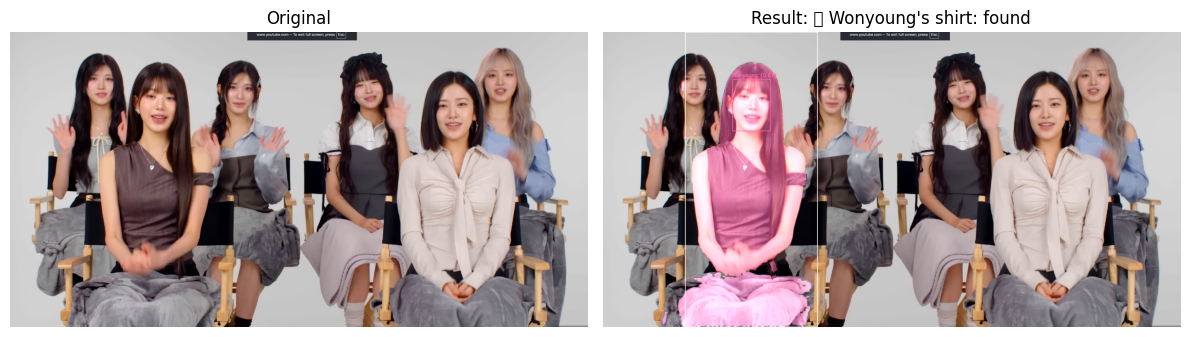

In [ ]:
# =============================================================================
# SECTION 8.3: Test - Segment Member's Object (e.g., Wonyoung's shirt)
# =============================================================================

# โหลดภาพตัวอย่าง
test_image = cv2.imread('/root/SEGMENTATION_IVE/Input/Input.png')  # แก้ path ตามภาพของคุณ

if test_image is not None:
    # Segment "Wonyoung's shirt"
    overlay, mask, status = pipeline.segment_member_objects(
        image_bgr=test_image,
        member_name='Wonyoung',
        object_text='shirt',
        embeddings_db=embeddings_db
    )
    
    print(status)
    
    # แสดงผล
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f'Result: {status}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("❌ ไม่พบภาพ กรุณาแก้ไข path หรืออัพโหลดภาพ")